In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import rasterio

%load_ext autoreload
%autoreload 2
pd.options.mode.chained_assignment = None

In [ ]:
## Kluge for now (shouldn't use sys append)
import sys
sys.path.append("/Users/dporter/Documents/Research/Projects/nasa_combined")

from nasa_combined.config import data_dir, data_path, cIce, cAir 

from nasa_combined.custom_funcs import *  # read_DICE_matfile, print_raster

print(data_path)

/Users/dporter/data/Antarctic/ROSETTA/radar


# Read in airborne data

In [5]:
suffix = '.csv'
datafile = 'oib_combined'

infile = os.path.join(data_path, 'for_COMBINED', datafile + suffix)
print(infile)

/Users/dporter/data/Antarctic/ROSETTA/radar/for_COMBINED/oib_combined.csv


## read in using Pandas and set `unixtime` as index

In [6]:
df = pd.read_csv(infile)
df.head()

,Line,PSX_3031,PSY_3031,UNIX,THICK,surface_atm_wrtg,surface_atm_thick,diff_radar_atm_thick
0,L1416698331,-3.827346e+06,1.347238e+06,1.416698e+09,NaN,NaN,NaN,NaN
1,L1416698331,-3.827426e+06,1.347249e+06,1.416698e+09,NaN,NaN,NaN,NaN
2,L1416698331,-3.827506e+06,1.347261e+06,1.416698e+09,NaN,NaN,NaN,NaN
3,L1416698331,-3.827585e+06,1.347273e+06,1.416698e+09,NaN,NaN,NaN,NaN
4,L1416698331,-3.827665e+06,1.347285e+06,1.416698e+09,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='PSX_3031', ylabel='PSY_3031'>

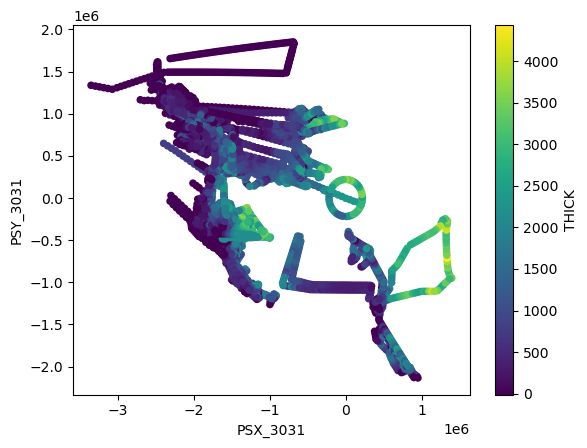

In [7]:
df[::500].plot.scatter(x = 'PSX_3031', y = 'PSY_3031', c = 'THICK')

In [8]:
import geopandas as gpd

fix_PROJ_path()

## Other outline options
# data/ASE_catchments_matchGL.geojson
# data/ASE_GroundingLine_simple.geojson

outlines = '../data/external/ASE_catchments+GL_3031.shp'

shapefile = gpd.read_file(outlines)

shapefile.head()

,groundedic,grounded_1,geometry
0,Grounded,GR,"POLYGON ((-1608074.997 -638549.999, -1608123.7..."
1,Grounded,GR,"POLYGON ((-1739481.254 -401608.850, -1740262.4..."
2,Grounded,GR,"POLYGON ((-1609325.000 -722675.000, -1609325.0..."
3,Grounded,GR,"MULTIPOLYGON (((-1604824.996 -612051.692, -160..."
4,Grounded,GR,"POLYGON ((-1908272.291 -410339.703, -1908540.1..."


(-1300000.0, -1100000.0)

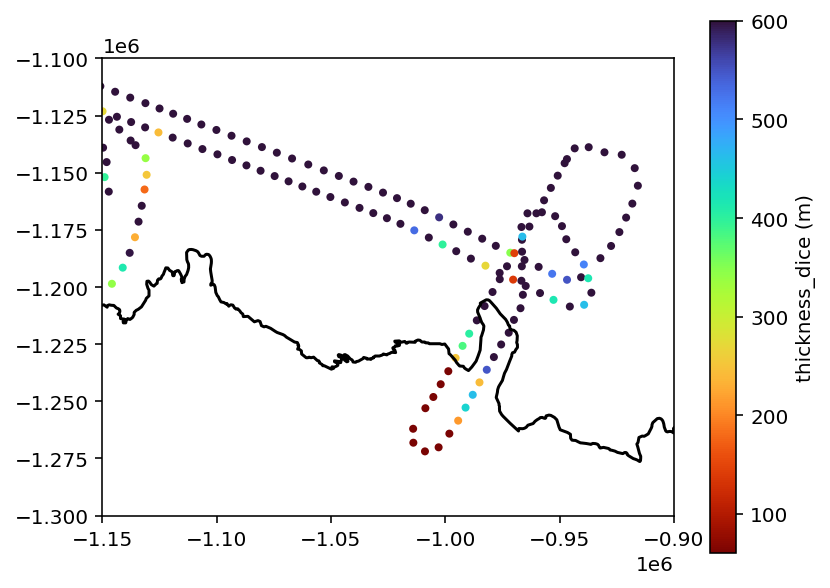

In [29]:
## Plot setup
grey_cmap = get_custom_cmap()
plot_i = 100


## Plot
fig, ax = plt.subplots(dpi=144)  # figsize=(8, 8), 
ax.set_aspect('equal')

shapefile.boundary.plot(ax=ax, edgecolor='black')

plt.scatter(df[::plot_i].PSX_3031, df[::plot_i].PSY_3031, 
            c=df[::plot_i].THICK,
            vmin=60, vmax=600,
            marker='.',
            cmap="turbo_r")
plt.colorbar(label="thickness_dice (m)")

# gdf[::500].plot(ax=ax, marker='x')
# plt.scatter(df_dice['EPSG_X'][::plot_i], df_dice['EPSG_Y'][::plot_i])

plt.xlim(-1.15e6, -0.9e6)
plt.ylim(-1.3e6, -1.1e6)

# plt.savefig('figs/mapplot_ROSETTA_ln720_channel.png')



In [30]:
def importOIBrad_all(raddir, date_flight):
    """
    :param basedir:
    :param timedir:
    :return:
    """
    from glob import glob
    # basedir = '/Users/dporter/Documents/data_local/OIB/OIB/'
    # datadir = 'IRMCR2'
    # infile = '2009_Antarctica_DC8'
    suffix = '.csv'
    pattern = os.path.join(raddir, '*'+date_flight+'*' + suffix)
    filenames = sorted(glob(pattern))  # , key=alphanum_key)
    filecounter = len(filenames)

    df_all = {}
    for fnum, filename in enumerate(filenames, start=0):
        # print "RADAR data file %i is %s" % (fnum, filename)
        df = pd.read_csv(filename, delimiter=",", na_values='-9999.00')
        df.rename(columns={'SURFACE': 'SURFACE_radar'}, inplace=True)

        ### do some DATETIME operations
        # df['DATE'] = str(df['FRAME'][0])[:8]
        df['FRAMESTR'] = df['FRAME'].apply(str)
        df['DATE'] = pd.to_datetime(list(df.FRAMESTR.str[:8]), format='%Y%m%d')
        del df['FRAMESTR']
        df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
        try:
            df['UNIX'] = df['UNIX'] + df['TIME']  # df['UTCTIMESOD']
        except KeyError:
            df['UNIX'] = df['UNIX'] + df['UTCTIMESOD']  # TODO: columns changed after 2016
        df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
        df = df.set_index('iunix')
        if fnum == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df])
    return df_all


date_flight = '20141102'
rad = importOIBrad_all(os.path.join('/Users/dporter/data/Antarctic/OIB/IRMCR2', '20141102_16'), date_flight)

(-142.0, -140.0)

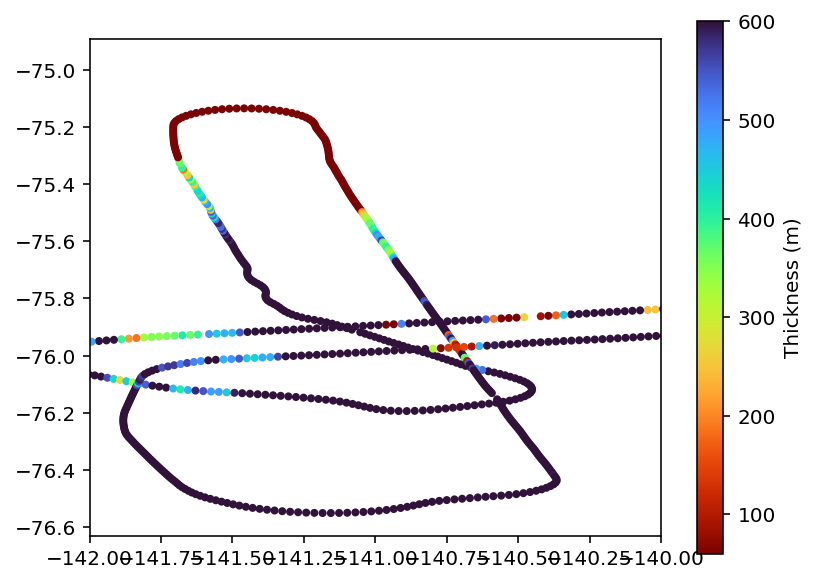

In [39]:
## Plot setup
grey_cmap = get_custom_cmap()
plot_i = 50


## Plot
fig, ax = plt.subplots(dpi=144)  # figsize=(8, 8), 
ax.set_aspect('equal')

# shapefile.boundary.plot(ax=ax, edgecolor='black')

plt.scatter(rad[::plot_i].LON, rad[::plot_i].LAT, 
            c=rad[::plot_i].THICK,
            vmin=60, vmax=600,
            marker='.',
            cmap="turbo_r")
plt.colorbar(label="Thickness (m)")

# gdf[::500].plot(ax=ax, marker='x')
# plt.scatter(df_dice['EPSG_X'][::plot_i], df_dice['EPSG_Y'][::plot_i])

plt.xlim(-142, -140)
# plt.ylim(-1.3e6, -1.1e6)

# plt.savefig('figs/mapplot_ROSETTA_ln720_channel.png')



In [36]:
rad.head()

,LAT,LON,UTCTIMESOD,THICK,ELEVATION,FRAME,SURFACE_radar,BOTTOM,QUALITY,DATE,UNIX
iunix,,,,,,,,,,,
2014-11-02 16:38:43.183000064,-74.972489,-132.077234,59923.1830,841.57,1369.6074,2014110216001,841.82,1683.39,1,2014-11-02,1.414946e+09
2014-11-02 16:38:43.284300032,-74.972520,-132.077470,59923.2843,840.34,1369.3374,2014110216001,841.34,1681.68,1,2014-11-02,1.414946e+09
2014-11-02 16:38:43.385499904,-74.972550,-132.077700,59923.3855,840.14,1369.0735,2014110216001,840.87,1681.01,1,2014-11-02,1.414946e+09
2014-11-02 16:38:43.486800128,-74.972580,-132.077930,59923.4868,839.18,1368.8093,2014110216001,840.40,1679.58,1,2014-11-02,1.414946e+09
2014-11-02 16:38:43.588000000,-74.972610,-132.078159,59923.5880,839.21,1368.5449,2014110216001,839.93,1679.14,1,2014-11-02,1.414946e+09


In [ ]:
# '''
# ICEBASE and SURFACE Recalc
# '''
# df_agg['surface_recalc'] = np.nan
# # dfout['surface_recalc'] = dfout['SURFACE_atm']
# # dfout.loc[dfout['surface_recalc'].isnull(), 'surface_recalc'] = dfout['TOPOGRAPHY_radar']
# # EXAMPLE df['X'] = np.where(df['Y'] >= 50, 'yes', 'no')
# df_agg['surface_recalc'] = np.where(df_agg['SURFACE_atm'].isnull(), df_agg['TOPOGRAPHY_radar'], df_agg['SURFACE_atm'])
# # print(('(sfc_atm - recalc) = {}'.format((df_agg.SURFACE_atm - df_agg.surface_recalc).max())))
# # print(('(TOPO_radar - recalc) = {}'.format((df_agg.TOPOGRAPHY_radar - df_agg.surface_recalc).max())))

# # ICEBASE
# df_agg['icebase_recalc'] = df_agg['surface_recalc']
# df_agg.loc[df_agg['surface_recalc'] != np.nan, 'icebase_recalc'] = (df_agg['surface_recalc'] - df_agg['THICK'])
# df_agg.loc[df_agg['surface_recalc'] == df_agg['icebase_recalc'], 'icebase_recalc'] = (df_agg['icebase_recalc'] - 1)

(-10.0, 2000.0)

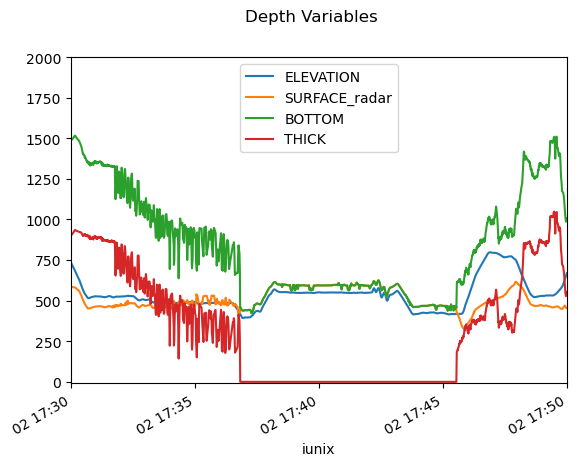

In [47]:
start_channel = '2014-11-02 17:30:00'
end_channel = '2014-11-02 17:50:00'

depth_vars = ['ELEVATION', 'SURFACE_radar', 'BOTTOM',
             'THICK', 
             ]

rad[depth_vars].plot(subplots=False)

plt.suptitle('Depth Variables')
plt.xlim(pd.Timestamp(start_channel), pd.Timestamp(end_channel))
plt.ylim([-10, 2000])

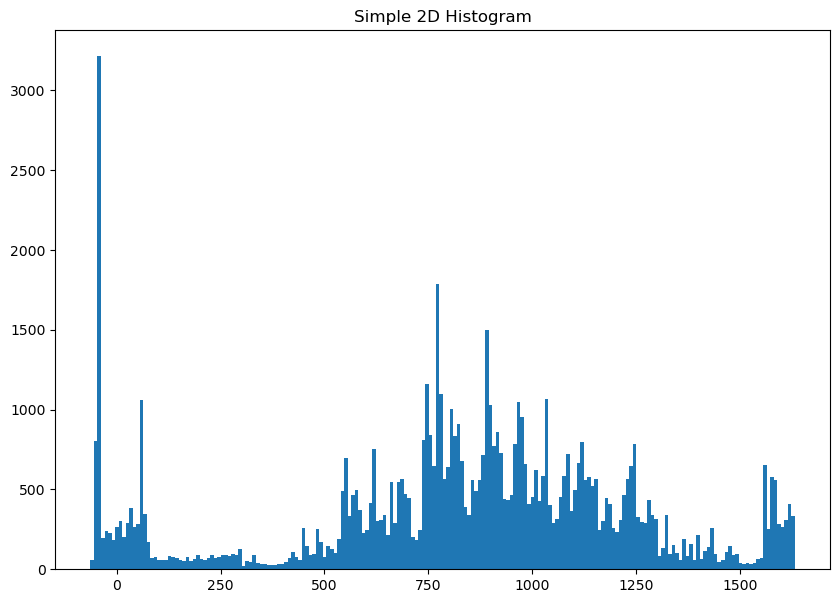

3216 counts of -46.03 m


In [66]:
fig = plt.subplots(figsize =(10, 7))

# Creating plot
# y, x, _ = plt.hist(df['rosetta_lidar_wrtgeo'], bins=200)
y, x, _ = plt.hist(rad['TOPOGRAPHY_radar'], bins=200)

 # = plt.hist(hdata)

plt.title("Simple 2D Histogram")

# show plot
plt.show()

print(f'{y.max():0.0f} counts of {x[y.argmax()]:0.2f} m')


In [126]:
mode = min(np.mean(rad['TOPOGRAPHY_radar'][:10]), np.mean(rad['TOPOGRAPHY_radar'][10:]))
print(mode)

528.7161899999999


In [115]:
rad['ICEBASE'] = rad['ELEVATION'] - rad['BOTTOM']
rad['TOPOGRAPHY_radar'] = rad['ELEVATION'] - rad['SURFACE_radar']

In [115]:
## Function
rad['THICK_hydro'] = calc_hydrostatic_thickness((-46.03 - rad['TOPOGRAPHY_radar']), 0.917)
rad.loc[:, 'HYDROAPPX'] = rad['TOPOGRAPHY_radar'] - rad['THICK_hydro']

## Calc (like OIB_all.py script)
# dflst[dnum].loc[:, 'HYDROAPPX'] = (clevel - (dflst[dnum]['SURFACE_atm'] - clevel) * 7.759)  # or SURFACE_atm
rad.loc[:, 'HYDROAPPXv2'] =   ((-46.03 - rad['TOPOGRAPHY_radar'].values) * 7.759) - 46.03



# NaN
rad.loc[rad['HYDROAPPX'] < -1500, 'HYDROAPPX'] = np.nan

(-1000.0, 300.0)

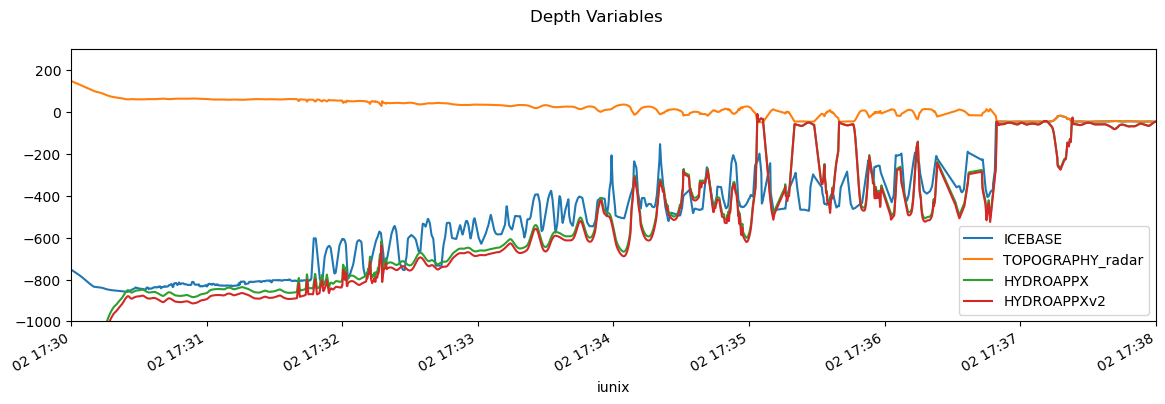

In [123]:
start_channel = '2014-11-02 17:30:00'
end_channel = '2014-11-02 17:38:00'

depth_vars = ['ICEBASE', 'TOPOGRAPHY_radar', 
              'HYDROAPPX', 'HYDROAPPXv2',
             ]

fig, ax = plt.subplots(figsize =(14, 4))
rad[depth_vars].plot(ax=ax, subplots=False)

plt.suptitle('Depth Variables')
plt.xlim(pd.Timestamp(start_channel), pd.Timestamp(end_channel))
plt.ylim([-1000, 300])


In [189]:
from nasa_combined.OIB_func import  haversine, calc_distance

rad['DIST'] = calc_distance(rad['LAT'].values, rad['LON'].values)

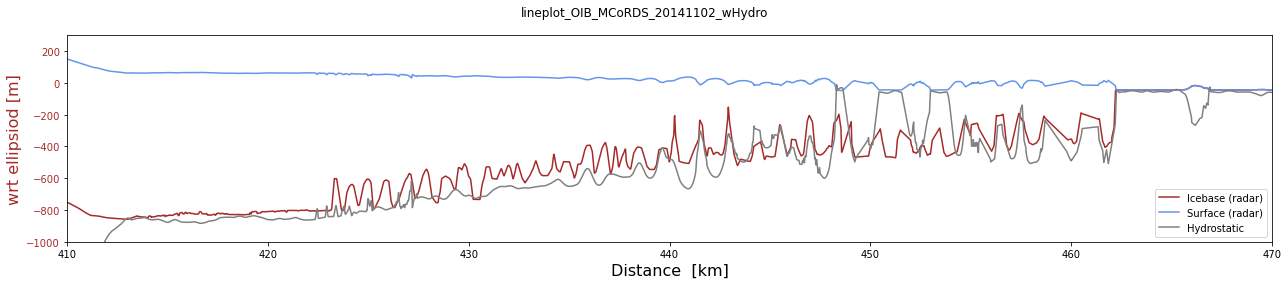

In [190]:
fig, ax = plt.subplots(figsize=(18, 4), dpi=72)

ax.plot(rad['DIST'], rad['ICEBASE'], label='Icebase (radar)', color='brown')
ax.tick_params(axis='y', labelcolor='brown')
ax.set_ylabel('wrt ellipsiod [m]', color='brown', fontsize=16)
ax.set_xlabel('Distance  [km]', color='black', fontsize=16)
# add_basin_locs()

ax.plot(rad['DIST'], rad['TOPOGRAPHY_radar'], color='cornflowerblue', 
        label='Surface (radar)', ls='-', marker='')
# ax.tick_params(axis='y', labelcolor='cornflowerblue')
# ax.set_ylabel('Icebase DICE', color='cornflowerblue', fontsize=16)

ax.plot(rad['DIST'], rad['HYDROAPPX'], color='grey', 
        label='Hydrostatic', ls='-', marker='')

plt.ylim([-1000, 300])
plt.xlim([410, 470])
plt.legend()
plt.suptitle(f'lineplot_OIB_MCoRDS_{date_flight}_wHydro')
plt.tight_layout()
plt.savefig(f'figs/lineplot_OIB_MCoRDS_{date_flight}_wHydro.png')

## READ in old school, pre-compiled `agg2invert` files
downside is these are 2Hz I think

In [179]:
df_agg = pd.read_csv(os.path.join(data_path, 
                                  'for_COMBINED',
                                  'OIB_ANT_2014-11-02' + suffix),
                    )
df_agg.columns
                     

Index(['iunix', 'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY',
       'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR', 'INTCOR', 'FAG070',
       'FAG100', 'FAG140', 'FLTENVIRO', 'UNIX', 'THICK', 'ELEVATION', 'FRAME',
       'SURFACE_radar', 'BOTTOM', 'QUALITY', 'SURFACE_atm', 'NUMUSED',
       'ICEBASE', 'TOPOGRAPHY_radar', 'D_gravmask', 'LINE', 'HYDROAPPX'],
      dtype='object')

In [182]:
from nasa_combined.OIB_func import  haversine, calc_distance

df_agg['DIST'] = calc_distance(df_agg['LAT'].values, df_agg['LONG'].values)

In [186]:
# SURFACE
df_agg['surface_recalc'] = np.nan
df_agg['surface_recalc'] = np.where(df_agg['SURFACE_atm'].isnull(), df_agg['TOPOGRAPHY_radar'], df_agg['SURFACE_atm'])

# ICEBASE
df_agg['icebase_recalc'] = df_agg['surface_recalc']
df_agg.loc[df_agg['surface_recalc'] != np.nan, 'icebase_recalc'] = (df_agg['surface_recalc'] - df_agg['THICK'])
# df_agg.loc[df_agg['surface_recalc'] == df_agg['icebase_recalc'], 'icebase_recalc'] = (df_agg['icebase_recalc'] - 1)

In [187]:
df_agg['surface_recalc'].interpolate(method='pad', inplace=True)
df_agg['icebase_recalc'].interpolate(method='linear', limit_area='inside', axis=0, inplace=True)
# df_agg['icebase_recalc'].interpolate(method='spline', order=1, s=0., axis=0, limit_area='inside', inplace=True)

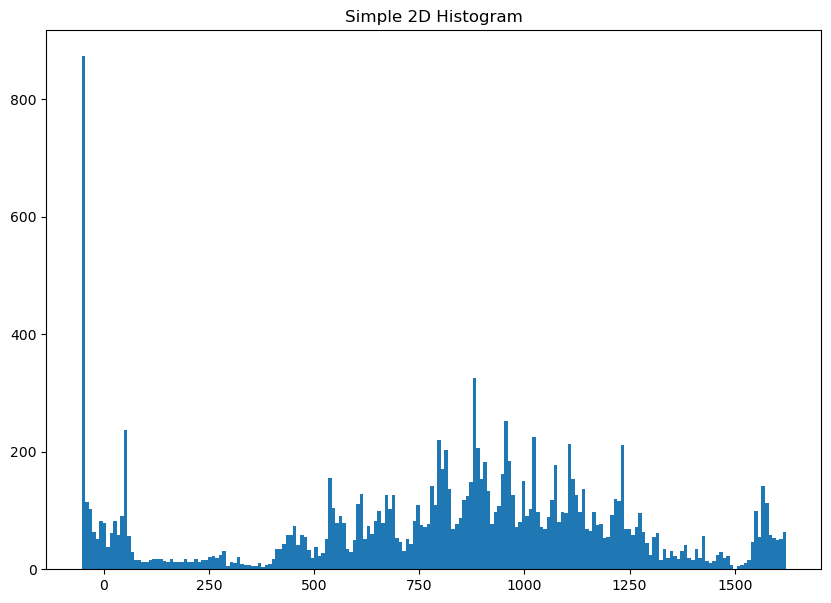

874 counts of -52.71 m


In [200]:
fig = plt.subplots(figsize =(10, 7))

# Creating plot
# y, x, _ = plt.hist(df['rosetta_lidar_wrtgeo'], bins=200)
y, x, _ = plt.hist(df_agg['SURFACE_atm'], bins=200)

 # = plt.hist(hdata)

plt.title("Simple 2D Histogram")

# show plot
plt.show()

print(f'{y.max():0.0f} counts of {x[y.argmax()]:0.2f} m')


In [210]:
## Function
clevel = -50.71  # TOPO_radar=-46.03, surface_recalc=-16.54, ATM=-52.71

df_agg['THICK_hydro'] = calc_hydrostatic_thickness((clevel - df_agg['surface_recalc']), 0.917)
df_agg.loc[:, 'HYDROAPPX'] = df_agg['surface_recalc'] - df_agg['THICK_hydro']

# NaN
# df_agg.loc[rad['HYDROAPPX'] < -1500, 'HYDROAPPX'] = np.nan

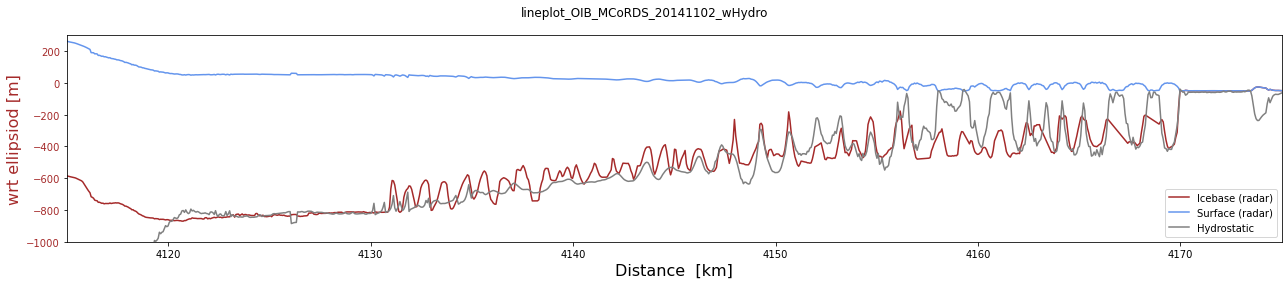

In [211]:
fig, ax = plt.subplots(figsize=(18, 4), dpi=72)

ax.plot(df_agg['DIST'], df_agg['icebase_recalc'], label='Icebase (radar)', color='brown')
ax.tick_params(axis='y', labelcolor='brown')
ax.set_ylabel('wrt ellipsiod [m]', color='brown', fontsize=16)
ax.set_xlabel('Distance  [km]', color='black', fontsize=16)
# add_basin_locs()

ax.plot(df_agg['DIST'], df_agg['surface_recalc'], color='cornflowerblue', 
        label='Surface (radar)', ls='-', marker='')
# ax.tick_params(axis='y', labelcolor='cornflowerblue')
# ax.set_ylabel('Icebase DICE', color='cornflowerblue', fontsize=16)

ax.plot(df_agg['DIST'], df_agg['HYDROAPPX'], color='grey', 
        label='Hydrostatic', ls='-', marker='')

plt.ylim([-1000, 300])
plt.xlim([4115, 4175])
plt.legend()
plt.suptitle(f'lineplot_OIB_MCoRDS_{date_flight}_wHydro')
plt.tight_layout()
plt.savefig(f'figs/lineplot_OIB_agg2Hz_{date_flight}_wHydro.png')